In [102]:
import os
import glob
import time
import random

import matplotlib.pylab as plt
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot') 

#font = {'family':'Osaka'}
font = {'family': 'IPAexGothic'}
matplotlib.rc('font', **font)

### Load datasets

In [2]:
num_train_data = 20000
num_test_data = 10000
len_img = 30
particle_dict = {'gamma':int(1), 'mu+':int(2), 'mu-':2}

In [3]:
t_start = time.time()

data_files = glob.glob('/Users/Kevin/Dropbox/data_30x30/*/*')
random.shuffle(data_files)
print('There are {} data-files.'.format(len(data_files)))

# Prepare np.ndarray
train_data = np.empty((num_train_data, len_img, len_img), int)
train_labels = np.empty((num_train_data,), int)
test_data = np.empty((num_test_data, len_img, len_img), int)
test_labels = np.empty((num_test_data,), int)

# load train_data
for n in range(num_train_data):
    with open(data_files[n], 'r') as data_file:
        lines = data_file.readlines()
        for i in range(len_img):
            for j in range(len_img):
                train_data[[n], [i], [j]] = lines[i][j] 
        
        train_labels[n] = particle_dict[lines[len_img]]
        
        
    if (n+1) % 2000 == 0:
        print('{:5d} files for train_data have loaded.'.format(n+1))

# load test_data
for n in range(num_test_data):
    with open(data_files[n + num_train_data], 'r') as data_file:
        lines = data_file.readlines()
        for i in range(len_img):
            for j in range(len_img):
                test_data[[n], [i], [j]] = lines[i][j] 
        test_labels[n] = particle_dict[lines[len_img]]
        
    if (n+1) % 2000 == 0:
        print('{:5d} files for test_data have loaded.'.format(n+1))


train_data = np.array(train_data, dtype="float32")
train_labels = np.array(train_labels, dtype="int32")

test_data = np.array(test_data, dtype="float32")
test_labels = np.array(test_labels, dtype="int32")

t_end = time.time()
print('Data-loading has finished!')

There are 30152 data-files.
 2000 files for train_data have loaded.
 4000 files for train_data have loaded.
 6000 files for train_data have loaded.
 8000 files for train_data have loaded.
10000 files for train_data have loaded.
12000 files for train_data have loaded.
14000 files for train_data have loaded.
16000 files for train_data have loaded.
18000 files for train_data have loaded.
20000 files for train_data have loaded.
 2000 files for test_data have loaded.
 4000 files for test_data have loaded.
 6000 files for test_data have loaded.
 8000 files for test_data have loaded.
10000 files for test_data have loaded.
Data-loading has finished!


In [4]:
print(train_data.size)
print(train_data.shape, train_data.dtype)

18000000
(20000, 30, 30) float32


In [5]:
train_data_tensor = torch.from_numpy(train_data)
train_labels_tensor = torch.from_numpy(train_labels)
print(type(train_data_tensor), train_data_tensor.size())
print(type(train_labels_tensor), train_labels_tensor.size())
train_dataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_tensor)

<class 'torch.FloatTensor'> torch.Size([20000, 30, 30])
<class 'torch.IntTensor'> torch.Size([20000])


In [6]:
test_data_tensor = torch.from_numpy(test_data)
test_labels_tensor = torch.from_numpy(test_labels)
print(type(test_data_tensor), test_data_tensor.size())
print(type(test_labels_tensor), test_labels_tensor.size())
test_dataset = torch.utils.data.TensorDataset(test_data_tensor, test_labels_tensor)

<class 'torch.FloatTensor'> torch.Size([10000, 30, 30])
<class 'torch.IntTensor'> torch.Size([10000])


In [36]:
batch_size = 5
#batch_size = 1
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 4000
==>>> total testing batch number: 2000


/Users/Kevin/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


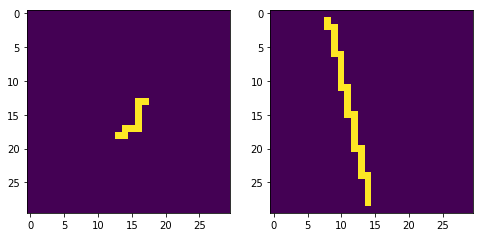

In [37]:
# 画像例
plt.figure(figsize=(8, 4))
for i in range(2):
    for images, labels in train_loader:
        if labels[0] == i+1:
            figure = images[0].view(30, 30)
            plt.subplot(121+i)
            plt.imshow(figure.numpy())#, cmap=cm.gray_r)
            break
plt.show()

### Definition of the model
* 微妙にネットワークと学習が間違っている説あり
 * ネットワークの出力が10のまま.....

In [80]:
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)  # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        #self.fc3   = nn.Linear(84, 2)
 
    def forward(self, x):
        # (1; 30, 30) -> (6; 26, 26) -> (6; 13, 13)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # Max pooling over a (2, 2) window
        
        # (6; 13, 13) -> (6; 10, 10) -> (16; 5, 5)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # If the size is a square you can only specify a single number
        
        # (16; 5, 5) ->[16*5*5]
        x = x.view(-1, self.num_flat_features(x))
        
        # [16*5*5] -> [120]
        x = F.relu(self.fc1(x))
        
        # [120] -> [84]
        x = F.relu(self.fc2(x))
        
        # [84] -> [10]
        x = self.fc3(x)
        return x
 
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Variables
You must choose these values carefully.

In [91]:
learning_rate = 0.001
num_epochs = 5
momentum = 0.9
num_miss_checks = 20

### Settings

In [92]:
net = Net()
#print(net)

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum = momentum)

In [94]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


### Training the Network

In [95]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    
    inputs = inputs.view(5,1,30,30)
    if i == 0:
        print(inputs.size(), type(inputs))
        print(labels.size(), type(labels))

torch.Size([5, 1, 30, 30]) <class 'torch.FloatTensor'>
torch.Size([5]) <class 'torch.LongTensor'>


In [96]:
t_start = time.time()
loss_fns = []

for epoch in range(num_epochs):  # 全データを複数回(num_epoch回)学習させる
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 入力を得る
        inputs, labels = data
        inputs = inputs.view(5,1,30,30)
 
        # それらを Variable にラップする
        inputs, labels = Variable(inputs), Variable(labels)
 
        # parameter 勾配をゼロにする
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        # 統計表示
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に出力
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            loss_fns.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

t_end = time.time()
print('Time for training : {} sec'.format(t_end - t_start))

[1,  2000] loss: 0.279
[1,  4000] loss: 0.027
[2,  2000] loss: 0.011
[2,  4000] loss: 0.006
[3,  2000] loss: 0.005
[3,  4000] loss: 0.003
[4,  2000] loss: 0.003
[4,  4000] loss: 0.002
[5,  2000] loss: 0.001
[5,  4000] loss: 0.002
Finished Training
Time for training : 69.97342300415039 sec


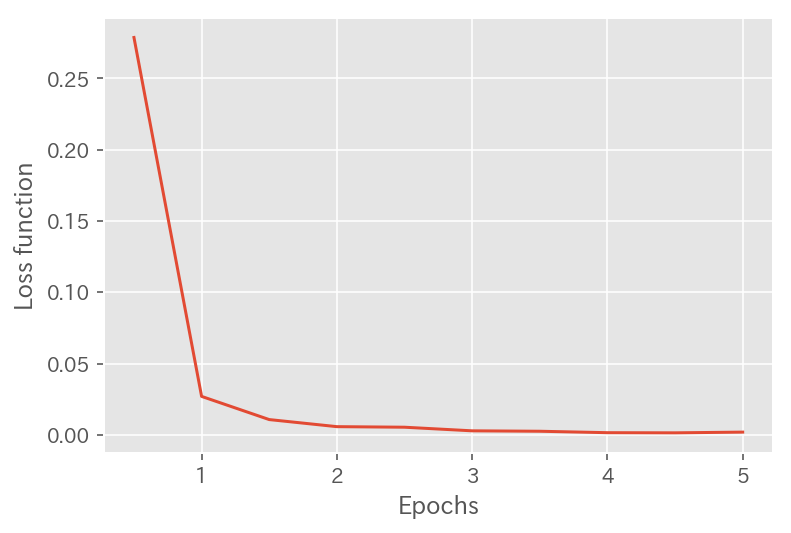

In [103]:
epochs = np.arange(1.0/2.0, 11.0/2.0, 1.0/2.0)
epochs
plt.plot(epochs, loss_fns)
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.show()

### Testing the Network with test-data

In [98]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images = images.view(5,1,30,30)
    
    # Accuracy Rate
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1) # torch.max(input, dim) : 全dim行毎に、maxを取りそのvalueとargのTensorを返す
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 10000 test images: %4.2lf %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99.90 %


In [99]:
print(correct, total)

9990 10000


### Show images that were mistaken

Pred : 2  /  Ans : 1


/Users/Kevin/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


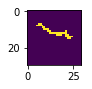

---------------------------------------------
Pred : 2  /  Ans : 1


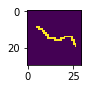

---------------------------------------------
Pred : 2  /  Ans : 1


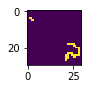

---------------------------------------------
Pred : 2  /  Ans : 1


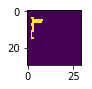

---------------------------------------------
Pred : 2  /  Ans : 1


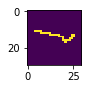

---------------------------------------------
Pred : 2  /  Ans : 1


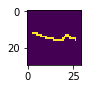

---------------------------------------------
Pred : 2  /  Ans : 1


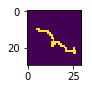

---------------------------------------------
Pred : 2  /  Ans : 1


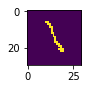

---------------------------------------------
Pred : 2  /  Ans : 1


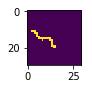

---------------------------------------------
Pred : 2  /  Ans : 1


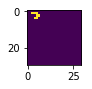

---------------------------------------------


In [100]:
miss = 0
for data in test_loader:
    images, labels = data
    images = images.view(5,1,30,30)
    
    # Accuracy Rate
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    
    # 間違えた画像の表示
    for j in range(len(images)):
        if miss < num_miss_checks and predicted[j] != labels[j]:
            print('Pred : {}  /  Ans : {}'.format(predicted[j], labels[j]))
            figure = images[j].view(30, 30)
            # 描画については、０から のch03/mnist.pyも参照
            plt.figure(figsize=(1, 1))
            plt.imshow(figure.numpy())#, cmap=cm.gray_r)
            plt.show()
            print('---------------------------------------------')
            miss += 1